# Mass Spring System

In [2]:
# We define the mass spring system as follows:
class Spring():
    def __init__(self, k=2.5, m=1.5, g=9.81):
        self.k = k # spring stiffness
        self.m = m # mass
        self.g = g # gravitational constant
        
    def deriv(self, state, t):
        # State equals [y, dy], derivative returns [dy, ddy]
        ddy = ((-self.k * state[0]) / self.m) + self.g
        return [state[1], ddy]

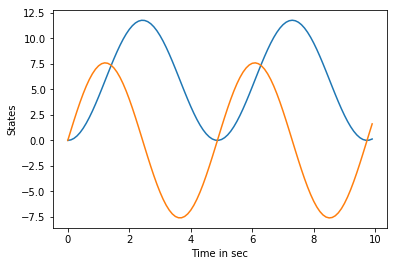

In [5]:
# We can integrate the system from starting point using scipy.integrate
from scipy.integrate import odeint
import numpy as np

# Define the dynamical system we want to estimate
system = Spring()
t = np.arange(0.0, 10.0, 0.1)
y0 = [0.0, 0.0]
y = odeint(system.deriv, y0, t)

# Make plots
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(t, y)
plt.xlabel('Time in sec')
plt.ylabel('States')
plt.show()

In [6]:
# We now want to learn system behavior from the data
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.integrators.simple import Euler, RungeKutta4

# Make tensors
tt = torch.tensor(t, dtype=torch.float).reshape(-1, 1)
yt = torch.tensor(y, dtype=torch.float).reshape(-1, 2)

# The model parameterizes the gradient
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.output = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t, y):
        return self.output(y)

method = RungeKutta4
model = Model(2, 64, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

# Define training settings
steps = 5000
for s in range(steps):
    # Make a batch of trajectories
    t0, t1 = tt[:-1], tt[1:]
    y0, y1 = yt[:-1], yt[1:]

    # Bootstrap a step from yt
    yp = method.step(model, t0, t1 - t0, y0)

    # Generate perturbations according to the avg absolute value
    y_norm = y0.abs().mean(0)

    # Take a positive and negative step
    y0p, y0m = y0 + y_norm / 50, y0 - y_norm / 50 # 2% deviation

    # Bootstrap both + / - perturbations
    ypp = method.step(model, t0, t1 - t0, y0p)
    ypm = method.step(model, t0, t1 - t0, y0m)

    # Optimize
    loss = torch.sum((yp - y1) ** 2) 
    p_loss = torch.sum(((ypp + ypm) / 2 - y1) ** 2)
    optimizer.zero_grad()
    (loss + p_loss).backward()
    optimizer.step()
    print("Real loss:", loss.item(), "Perturbed loss:", p_loss.item())

Real loss: 78.81205749511719 Perturbed loss: 78.81002044677734
Real loss: 55.00624084472656 Perturbed loss: 55.00994110107422
Real loss: 35.25288772583008 Perturbed loss: 35.25543212890625
Real loss: 30.184396743774414 Perturbed loss: 30.173547744750977
Real loss: 18.580080032348633 Perturbed loss: 18.575410842895508
Real loss: 13.623655319213867 Perturbed loss: 13.616034507751465
Real loss: 12.845705032348633 Perturbed loss: 12.807196617126465
Real loss: 14.628203392028809 Perturbed loss: 14.584206581115723
Real loss: 32.542301177978516 Perturbed loss: 32.43874740600586
Real loss: 17.71282196044922 Perturbed loss: 17.660676956176758
Real loss: 11.288491249084473 Perturbed loss: 11.230772018432617
Real loss: 9.612686157226562 Perturbed loss: 9.520703315734863
Real loss: 8.150467872619629 Perturbed loss: 8.08893871307373
Real loss: 5.706090450286865 Perturbed loss: 5.694030284881592
Real loss: 4.775424003601074 Perturbed loss: 4.772226333618164
Real loss: 5.691025733947754 Perturbed los

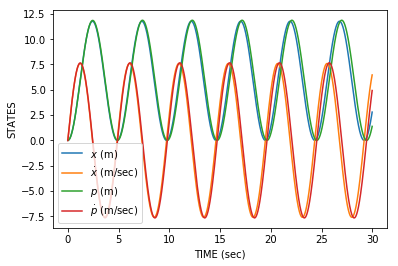

In [8]:
# Make un-bootstrapped trajectory of new (slightly changed) state 0
step_size = 0.01
t = np.arange(0.0, 30.0, step_size)
y0 = [0.0, 0.0]
y = odeint(system.deriv, y0, t)
yt = torch.tensor(y, dtype=torch.float)
yp = torch.zeros_like(yt)
yp[0, :] = yt[0, :] + torch.randn_like(yt[0, :]) * step_size
for i in range(len(t) - 1):
    yp[i + 1] = method.step(model, t[i], t[i + 1] - t[i], yp[i])

# Make plots
plt.plot(t, y)
plt.plot(t, yp.detach().numpy())
plt.xlabel('TIME (sec)')
plt.ylabel('STATES')
plt.legend(('$x$ (m)', '$\dot{x}$ (m/sec)', '$p$ (m)', '$\dot{p}$ (m/sec)'))
plt.show()

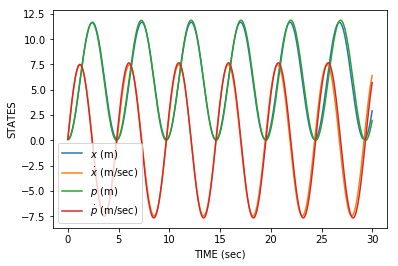

In [9]:
# Make un-bootstrapped trajectory of new (slightly changed) state 0
t = np.arange(0.0, 30.0, step_size)
y0 = [0.1, 0.1]
y = odeint(system.deriv, y0, t)
yt = torch.tensor(y, dtype=torch.float)
yp = torch.zeros_like(yt)
yp[0, :] = yt[0, :] + torch.randn_like(yt[0, :]) * step_size
for i in range(len(t) - 1):
    yp[i + 1] = method.step(model, t[i], t[i + 1] - t[i], yp[i])

plt.plot(t, y)
plt.plot(t, yp.detach().numpy())
plt.xlabel('TIME (sec)')
plt.ylabel('STATES')
plt.legend(('$x$ (m)', '$\dot{x}$ (m/sec)', '$p$ (m)', '$\dot{p}$ (m/sec)'))
plt.show()